In [83]:
import sys
import warnings
import math
import datetime
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import plotly
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
from plotly.subplots import make_subplots

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional

In [84]:
# Températures, Humidité
Temp_HR = ['N1NTemp', 'N1ETemp', 'N1STemp', 'N1OTemp', 'S1NTemp', 'S1OTemp', 'N2STemp', 'N2OTemp', 'N2ETemp', 'N2NTemp', 'S2STemp', 'S2OTemp', 'S2ETemp', 'S2NTemp', 'N2SHR', 'N2OHR', 'N2EHR', 'N2NHR', 'S2SHR', 'S2OHR', 'S2EHR', 'S2NHR']

# Humidité, Températures (Tour Nord 2 Etages)
tour_nord_2_temp_HR = [("N2STemp", "N2SHR"), ("N2OTemp", "N2OHR"), ("N2ETemp", "N2EHR"), ("N2NTemp", "N2NHR")]
tour_sud_2_temp_HR = [("S2STemp", "S2SHR"), ("S2OTemp", "S2OHR"), ("S2ETemp", "S2EHR"), ("S2NTemp", "S2NHR")]

In [85]:
def split_dataframe(df, train_size=0.7, val_size=0.2):
    """
    Découpe un DataFrame temporel en trois parties : train, val, test,
    en respectant l'ordre chronologique.

    Args:
        df (pd.DataFrame): Données à découper (indexé ou non par le temps)
        train_size (float): Proportion pour l'ensemble d'entraînement
        val_size (float): Proportion pour la validation

    Returns:
        df_train, df_val, df_test (DataFrames)
    """
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    print(f"Train size : {len(df_train)}")
    print(f"Val size : {len(df_val)}")
    print(f"Test size : {len(df_test)}")

    return df_train, df_val, df_test

In [86]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

    """
This function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.

    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.
    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.
    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.
    """

#### **DRIAS RCP Dataset**

In [87]:
data_rcp_2_6 = pd.read_excel('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_2_6['Date'] = pd.to_datetime(data_rcp_2_6['Date'], format='%d/%m/%Y')
data_rcp_2_6.set_index('Date', inplace=True)
data_rcp_2_6.tail()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2100-12-27,49.2427,4.03882,0.67,4.61,2.63,0.000,0.000,3.508,53.907,263.422,12.37,0.591
2100-12-28,49.2427,4.03882,-0.74,2.53,0.72,1.015,0.644,3.386,12.878,314.804,13.65,0.432
2100-12-29,49.2427,4.03882,-1.10,1.20,-0.24,0.381,0.381,3.521,18.212,310.789,4.29,0.185
2100-12-30,49.2427,4.03882,-3.13,0.07,-1.50,0.069,0.000,2.961,11.396,312.622,5.85,0.196
2100-12-31,49.2427,4.03882,-1.72,2.36,0.88,0.192,0.091,3.459,31.068,300.079,5.88,0.183


In [88]:
data_rcp_4_5 = pd.read_excel('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_4_5['Date'] = pd.to_datetime(data_rcp_4_5['Date'], format='%d/%m/%Y')
data_rcp_4_5.set_index('Date', inplace=True)
data_rcp_4_5.tail()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2100-12-27,49.2427,4.03882,1.00,9.48,4.55,0.000,0.0,4.967,51.618,286.619,11.37,0.200
2100-12-28,49.2427,4.03882,4.14,11.98,8.26,3.633,0.0,5.910,38.051,318.954,14.50,0.370
2100-12-29,49.2427,4.03882,4.61,9.58,8.07,2.746,0.0,5.180,30.541,324.057,15.67,0.614
2100-12-30,49.2427,4.03882,6.15,10.11,7.57,9.368,0.0,5.884,17.554,334.634,36.97,0.764
2100-12-31,49.2427,4.03882,5.40,6.59,6.08,2.348,0.0,5.043,15.093,337.720,18.19,0.618


In [89]:
data_rcp_8_5 = pd.read_excel('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp8.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_8_5['Date'] = pd.to_datetime(data_rcp_8_5['Date'], format='%d/%m/%Y')
data_rcp_8_5.set_index('Date', inplace=True)
data_rcp_8_5.tail()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2100-12-27,49.2427,4.03882,-0.66,6.08,1.58,0.070,0.000,3.103,51.761,285.622,7.58,0.496
2100-12-28,49.2427,4.03882,1.82,4.38,3.04,0.265,0.000,4.683,21.316,340.201,1.68,0.139
2100-12-29,49.2427,4.03882,2.17,6.72,5.15,0.463,0.136,4.927,17.369,342.966,8.96,0.158
2100-12-30,49.2427,4.03882,5.94,8.88,7.38,0.088,0.000,5.873,11.491,356.660,15.39,0.380
2100-12-31,49.2427,4.03882,6.48,9.47,8.05,4.551,0.000,6.147,11.166,358.290,31.71,0.480


#### **Dataset Historique-Météo** 

In [90]:
# Liste des années à importer
annees = range(2009, 2026)

# Liste pour stocker les DataFrames
dfs = []

# Boucle sur les années
for annee in annees:
    nom_fichier = f"Historique-Météo/export-reims{annee}.csv"
    df = pd.read_csv(nom_fichier, skiprows=3)
    dfs.append(df)

# Concatène tous les DataFrames en un seul
data_climate_reims_2009_2025 = pd.concat(dfs, ignore_index=True)

In [91]:
data_climate_reims_2009_2025['DATE'] = pd.to_datetime(data_climate_reims_2009_2025['DATE'], format='%Y-%m-%d')
data_climate_reims_2009_2025.set_index('DATE', inplace=True)
data_climate_reims_2009_2025.head()

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C_6H,TEMPERATURE_NOON_C_12H,TEMPERATURE_EVENING_C_18H,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,...,TEMPERATURE_NIGHT_C_3H,WEATHER_CODE_NIGHT_3H,TEMPERATURE_9H,WEATHER_CODE_9H,TEMPERATURE_15H,WEATHER_CODE_15H,TEMPERATURE_21H,WEATHER_CODE_21H,TEMPERATURE_MIDNIGHT_0H,WEATHER_CODE_MIDNIGHT_0H
DATE,,,,,,,,,,,,,,,,,,,,,
2009-01-01,3,-4,8,-3,3,-3,0.0,95,7.00,1029,...,-3,143,-2,113,0,116,-4,113,-3,143
2009-01-02,1,-5,15,-5,1,-2,0.0,88,10.00,1028,...,-5,113,-4,113,0,113,-2,116,-5,113
2009-01-03,1,-5,14,-4,1,-4,0.0,93,10.00,1028,...,-3,116,-3,113,-1,113,-5,113,-3,116
2009-01-04,-1,-6,8,-6,-1,-4,0.0,68,10.00,1026,...,-6,116,-5,113,-3,119,-4,116,-6,113
2009-01-05,-1,-4,10,-4,-1,-2,2.5,83,3.75,1021,...,-4,338,-3,332,-1,338,-2,332,-4,119


In [92]:
# MEAN_TEMPERATURE_C
colonnes_temp_horaires = [
    'TEMPERATURE_MORNING_C_6H',
    'TEMPERATURE_NOON_C_12H',
    'TEMPERATURE_EVENING_C_18H',
    'TEMPERATURE_NIGHT_C_3H',
    'TEMPERATURE_9H',
    'TEMPERATURE_15H',
    'TEMPERATURE_21H',
    'TEMPERATURE_MIDNIGHT_0H'
]

# Calcul de la moyenne journalière basée uniquement sur les températures horaires
data_climate_reims_2009_2025['MEAN_TEMPERATURE_C'] = data_climate_reims_2009_2025[colonnes_temp_horaires].mean(axis=1)
data_climate_reims_2009_2025['MEAN_TEMPERATURE_C']

DATE
2009-01-01    -1.875
2009-01-02    -2.750
2009-01-03    -2.750
2009-01-04    -4.375
2009-01-05    -2.625
               ...  
2025-04-26    11.875
2025-04-27    14.250
2025-04-28    14.500
2025-04-29    14.750
2025-04-30    15.750
Name: MEAN_TEMPERATURE_C, Length: 5964, dtype: float64

In [93]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6.index.intersection(data_climate_reims_2009_2025.index)
data_rcp_2_6_2009_2025 = data_rcp_2_6.loc[common_index_data_rcp_2_6]

In [94]:
# récupérer les index communs data rcp4.5
common_index_data_rcp_4_5 = data_rcp_4_5.index.intersection(data_climate_reims_2009_2025.index)
data_rcp_4_5_2009_2025 = data_rcp_4_5.loc[common_index_data_rcp_4_5]

In [95]:
# récupérer les index communs data rcp8.5
common_index_data_rcp_8_5 = data_rcp_8_5.index.intersection(data_climate_reims_2009_2025.index)
data_rcp_8_5_2009_2025 = data_rcp_8_5.loc[common_index_data_rcp_8_5]

#### **Dataset Releve iButton Basilique Saint-Rémi**

In [96]:
data_basilique_2018_2019 = pd.read_excel('Releve iButton Basilique Saint Rémi\DATA_processing_iButton_2018_2019.xlsx',  index_col='Date Heure', parse_dates=True)
data_basilique_2018_2019.head()

,N1NTemp,N1ETemp,N1STemp,N1OTemp,S1NTemp,S1OTemp,N2STemp,N2OTemp,N2ETemp,N2NTemp,...,S2ETemp,S2NTemp,N2SHR,N2OHR,N2EHR,N2NHR,S2SHR,S2OHR,S2EHR,S2NHR
Date Heure,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:01,9.7,9.7,9.9,9.7,9.7,9.3,9.8,9.7,9.7,9.6,...,9.9,9.6,77.4,78.9,77.7,78.3,79.4,82.8,77.9,78.5
2018-01-01 01:00:01,9.1,9.7,9.4,9.4,9.2,8.9,9.5,9.0,9.4,9.3,...,9.7,9.4,76.8,81.7,77.9,78.5,81.0,92.2,78.6,78.9
2018-01-01 02:00:01,9.0,9.0,8.9,9.0,9.1,8.2,9.0,8.9,8.9,8.8,...,9.2,8.9,75.9,76.5,76.6,77.7,77.7,80.8,77.9,77.5
2018-01-01 03:00:01,8.5,9.0,9.1,8.9,8.6,8.8,9.0,8.8,8.9,8.9,...,9.1,8.9,76.3,77.5,76.5,76.9,78.0,79.4,77.9,76.7
2018-01-01 04:00:01,7.7,8.5,8.1,6.9,7.9,7.5,8.1,8.0,8.1,8.0,...,8.6,8.0,78.2,81.0,79.2,79.2,78.3,87.6,78.2,80.0


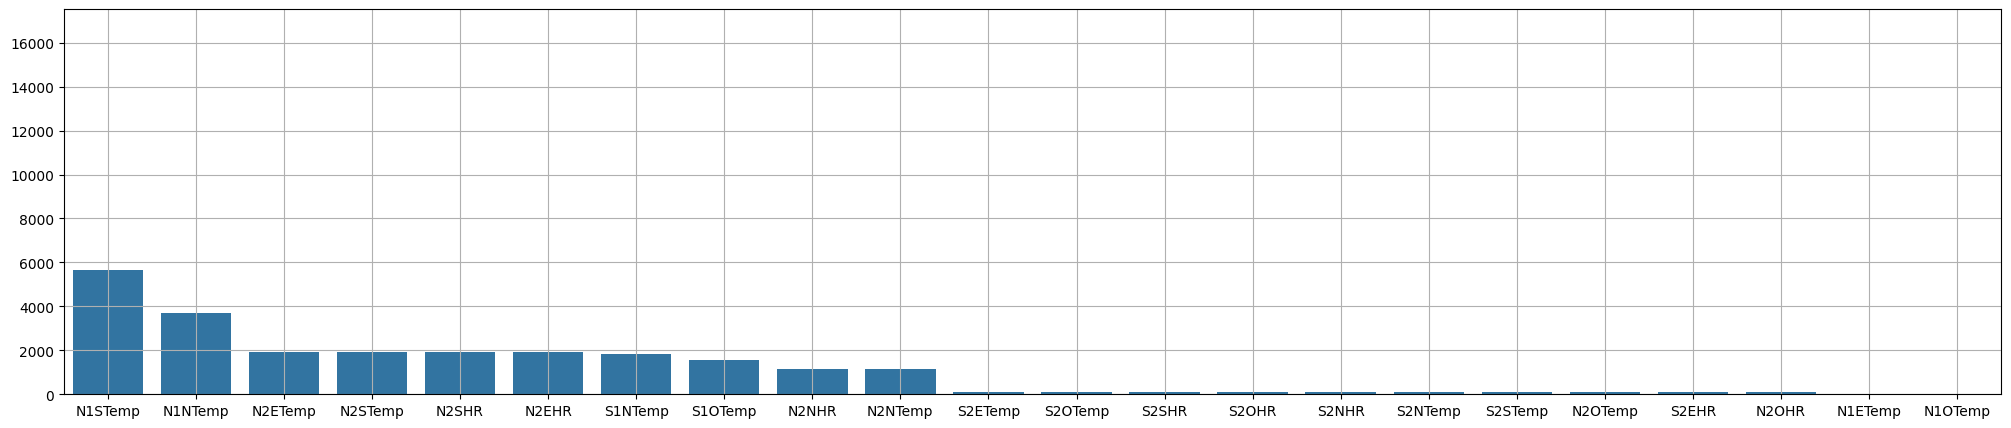

In [97]:
plt.figure(figsize=(25,5))
labels = data_basilique_2018_2019[Temp_HR].isnull().sum().sort_values(ascending=False).index.to_list()
sizes = data_basilique_2018_2019[Temp_HR].isnull().sum().sort_values(ascending=False).to_list()
sns.barplot(x=labels, y=sizes)
plt.grid()
plt.ylim((0.0, float(data_basilique_2018_2019.shape[0])))
plt.show()

In [98]:
data_bsr_2018_2019 = data_basilique_2018_2019.resample('D').mean().copy()
data_bsr_2018_2019 = data_bsr_2018_2019[["S2STemp", "S2SHR"]]
data_bsr_2018_2019 = data_bsr_2018_2019.interpolate(method='linear') ## Pour remplacer les valeurs NAN DU 2018-06-10, 2018-06-11, 2018-06-12, 2018-06-13
data_bsr_2018_2019

,S2STemp,S2SHR
Date Heure,,
2018-01-01,7.400000,91.754167
2018-01-02,6.787500,96.329167
2018-01-03,10.229167,82.954167
2018-01-04,10.091667,94.233333
2018-01-05,9.525000,90.345833
...,...,...
2019-12-27,8.545833,103.325000
2019-12-28,5.887500,93.720833
2019-12-29,4.000000,86.333333


In [99]:
dl_train, dl_val, dl_test = split_dataframe(data_bsr_2018_2019)

Train size : 510
Val size : 146
Test size : 74


In [100]:
minmax_scaler = MinMaxScaler()  # scaler for humidity
target_transformer = MinMaxScaler()   # scaler for target (meantemp)

In [101]:
dl_train['S2STemp'] = target_transformer.fit_transform(dl_train[['S2STemp']]) # target
dl_train['S2SHR'] = minmax_scaler.fit_transform(dl_train[['S2SHR']]) # minmax for humidity

dl_val['S2STemp'] = target_transformer.transform(dl_val[['S2STemp']])
dl_val['S2SHR'] = minmax_scaler.transform(dl_val[['S2SHR']])

dl_test['S2STemp'] = target_transformer.transform(dl_test[['S2STemp']])
dl_test['S2SHR'] = minmax_scaler.transform(dl_test[['S2SHR']])

In [102]:
# Create sequences
sequence_length = 3  # Example sequence length (adjust based on your data and experimentation)
X_train, y_train = create_dataset(dl_train, dl_train['S2STemp'], sequence_length)
X_val, y_val = create_dataset(dl_val, dl_val['S2STemp'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['S2STemp'], sequence_length)

In [103]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='tanh', input_shape=(sequence_length, X_train.shape[2]))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')

Epoch 1/30
507/507 [==============================] - 5s 4ms/step - loss: 0.0143 - val_loss: 0.0312
Epoch 2/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 3/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 4/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 5/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 6/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 7/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 8/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 9/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 10/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0065

In [104]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 200)               82400     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 82601 (322.66 KB)
Trainable params: 82601 (322.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
# Make predictions
bilstm_pred = model.predict(X_val)
bilstm_pred = target_transformer.inverse_transform(bilstm_pred)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_val = y_val.reshape(-1, 1)
y_val = target_transformer.inverse_transform(y_val)

5/5 [==============================] - 1s 2ms/step


In [113]:
len(y_val)

143

In [114]:
len(y_test)

71

In [115]:
len(y_train)

507

In [122]:
len(data_bsr_2018_2019)

730

RMSE: 2.48276155281923
R2 Score: 0.7543931947081063


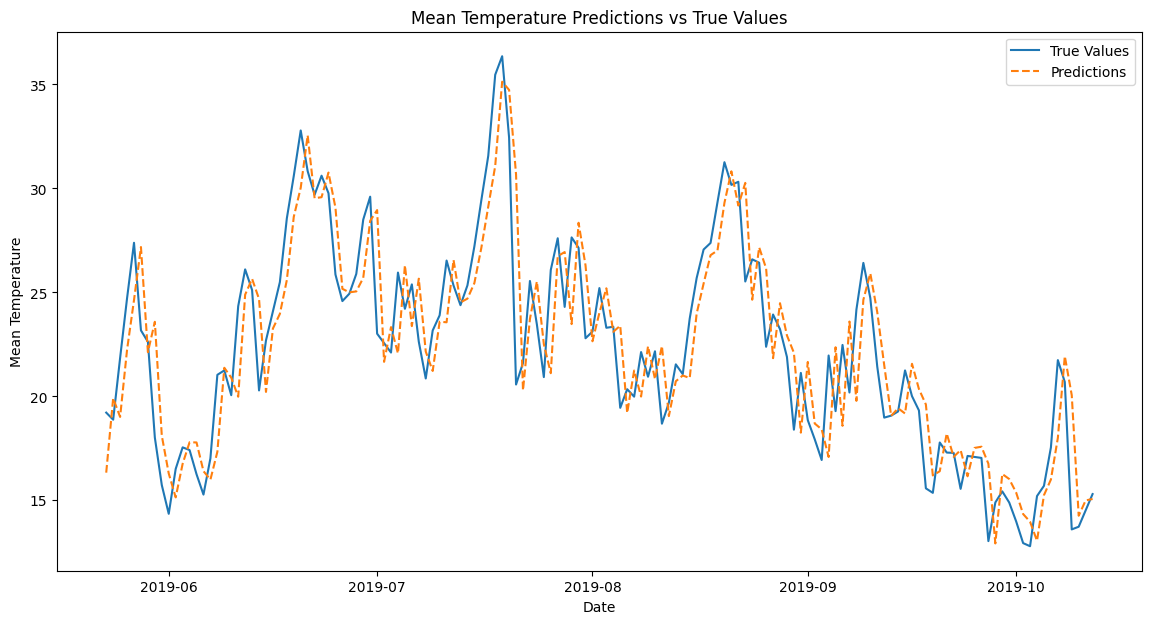

In [110]:
# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_val, bilstm_pred))
r2 = r2_score(y_val, bilstm_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_bsr_2018_2019.index[len(y_train): len(y_train) + len(y_val)], y_val, label='True Values')
plt.plot(data_bsr_2018_2019.index[len(y_train): len(y_train) + len(y_val)], bilstm_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

In [111]:
# Make predictions
bilstm_pred_test = model.predict(X_test)
bilstm_pred_test = target_transformer.inverse_transform(bilstm_pred_test)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)
y_test = target_transformer.inverse_transform(y_test)

3/3 [==============================] - 0s 3ms/step


In [124]:
len(y_train) + len(y_val)

650

In [127]:
y_test.shape

(71, 1)

In [126]:
len(bilstm_pred_test)

71

RMSE: 2.2886452442618803
R2 Score: 0.5224921813054066


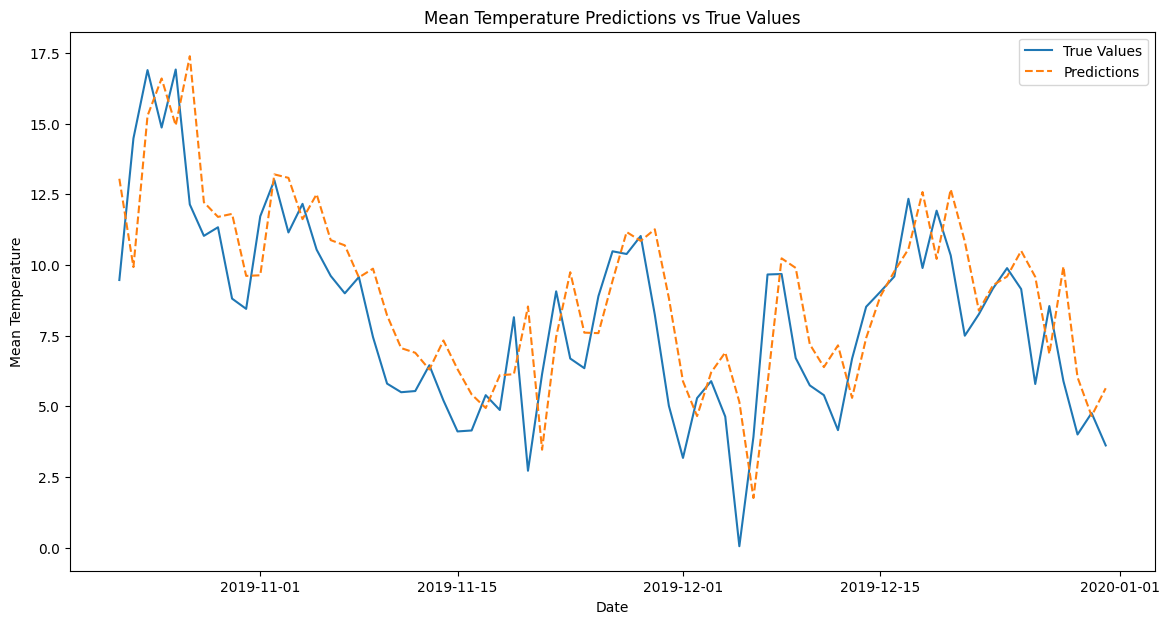

In [128]:
# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test, bilstm_pred_test))
r2 = r2_score(y_test, bilstm_pred_test)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_bsr_2018_2019.index[-len(y_test):], y_test, label='True Values')
plt.plot(data_bsr_2018_2019.index[-len(y_test):], bilstm_pred_test, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

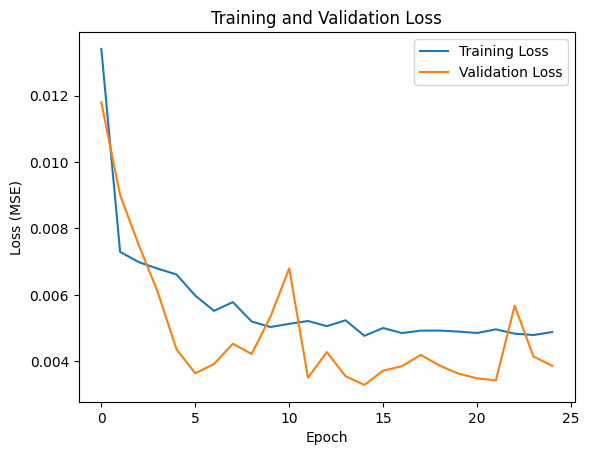

In [27]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### **Feature Selection** 

In [11]:
# data_rcp_4_5 = data_rcp_4_5[['tasAdjust', 'tasmaxAdjust', 'tasminAdjust', 'hussAdjust', 'evspsblpotAdjust']]
data_rcp_4_5 = data_rcp_4_5[['tasAdjust', 'hussAdjust', 'evspsblpotAdjust']]
data_rcp_4_5.head()

,tasAdjust,hussAdjust,evspsblpotAdjust
Date,,,
2006-01-01,-0.02,3.503,0.156
2006-01-02,2.03,5.015,0.047
2006-01-03,8.82,8.196,0.171
2006-01-04,11.92,7.773,0.473
2006-01-05,7.20,6.088,0.191


#### **Train Test Split**

In [12]:
# Split the data into training and testing sets
train_size = int(len(data_rcp_4_5) * 0.9)
dl_train, dl_test = data_rcp_4_5.iloc[:train_size], data_rcp_4_5.iloc[train_size:]
print(len(dl_train), len(dl_test))

31228 3470


In [13]:
dl_train, dl_test = dl_train.copy(), dl_test.copy()

In [14]:
data_rcp_4_5.columns

Index(['tasAdjust', 'hussAdjust', 'evspsblpotAdjust'], dtype='object')

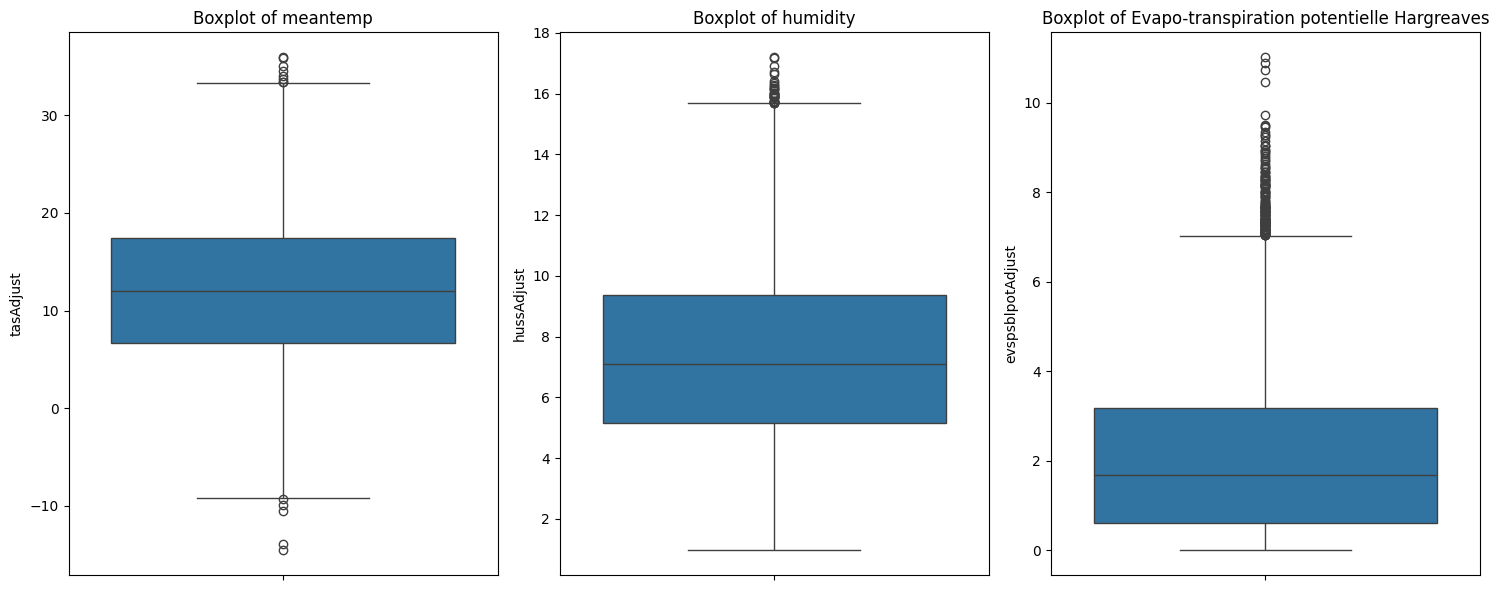

In [15]:
# find out what scaling to perform

f_columns = ['tasAdjust', 'hussAdjust', 'evspsblpotAdjust']
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1) 
sns.boxplot(y=data_rcp_4_5['tasAdjust'])
plt.title('Boxplot of meantemp')

""" plt.subplot(1, 5, 2) 
sns.boxplot(y=data_rcp_4_5['tasmaxAdjust'])
plt.title('Boxplot of maxtemp')

plt.subplot(1, 5, 3) 
sns.boxplot(y=data_rcp_4_5['tasminAdjust'])
plt.title('Boxplot of mintemp') """

plt.subplot(1, 3, 2) 
sns.boxplot(y=data_rcp_4_5['hussAdjust'])
plt.title('Boxplot of humidity')

plt.subplot(1, 3, 3) 
sns.boxplot(y=data_rcp_4_5['evspsblpotAdjust'])
plt.title('Boxplot of Evapo-transpiration potentielle Hargreaves')

plt.tight_layout() 
plt.show()

In [16]:
data_rcp_4_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34698 entries, 2006-01-01 to 2100-12-31
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tasAdjust         34698 non-null  float64
 1   hussAdjust        34698 non-null  float64
 2   evspsblpotAdjust  34698 non-null  float64
dtypes: float64(3)
memory usage: 2.1 MB


In [17]:
minmax_scaler_hussAdjust = MinMaxScaler()  # scaler for humidity
minmax_scaler_evspsblpotAdjust = MinMaxScaler()  # scaler for evspsblpotAdjust
target_transformer = MinMaxScaler()

In [18]:
dl_train['tasAdjust'] = target_transformer.fit_transform(dl_train[['tasAdjust']]) # target
dl_train['hussAdjust'] = minmax_scaler_hussAdjust.fit_transform(dl_train[['hussAdjust']]) # minmax for humidity
dl_train['evspsblpotAdjust'] = minmax_scaler_evspsblpotAdjust.fit_transform(dl_train[['evspsblpotAdjust']]) # minmax for evspsblpotAdjust

dl_test['tasAdjust'] = target_transformer.transform(dl_test[['tasAdjust']])
dl_test['hussAdjust'] = minmax_scaler_hussAdjust.transform(dl_test[['hussAdjust']])
dl_test['evspsblpotAdjust'] = minmax_scaler_evspsblpotAdjust.transform(dl_test[['evspsblpotAdjust']])

In [19]:
display(data_rcp_4_5.head())
display(dl_train.head())

,tasAdjust,hussAdjust,evspsblpotAdjust
Date,,,
2006-01-01,-0.02,3.503,0.156
2006-01-02,2.03,5.015,0.047
2006-01-03,8.82,8.196,0.171
2006-01-04,11.92,7.773,0.473
2006-01-05,7.20,6.088,0.191


,tasAdjust,hussAdjust,evspsblpotAdjust
Date,,,
2006-01-01,0.287891,0.156924,0.014325
2006-01-02,0.328453,0.250154,0.004316
2006-01-03,0.462802,0.446294,0.015702
2006-01-04,0.524139,0.420212,0.043434
2006-01-05,0.430748,0.316315,0.017539


In [20]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

"""
This function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.

    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.
    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.
    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.
"""

'\nThis function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.\n\n    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.\n    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.\n    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.\n'

In [ ]:
# Create sequences
sequence_length = 3  # Example sequence length (adjust based on your data and experimentation)
X_train, y_train = create_dataset(dl_train, dl_train['S2STemp'], sequence_length)
X_val, y_val = create_dataset(dl_test, dl_test['S2STemp'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['S2STemp'], sequence_length)

#### **Bi-LSTM**

In [21]:
# Create sequences
sequence_length = 3  # Example sequence length (adjust based on your data and experimentation)
X_train, y_train = create_dataset(dl_train, dl_train['tasAdjust'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['tasAdjust'], sequence_length)

In [22]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='tanh', input_shape=(sequence_length, X_train.shape[2]))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}')



Epoch 1/30

31225/31225 [==============================] - 57s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 2/30
31225/31225 [==============================] - 53s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/30
31225/31225 [==============================] - 53s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/30
31225/31225 [==============================] - 53s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/30
31225/31225 [==============================] - 54s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/30
31225/31225 [==============================] - 54s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/30
31225/31225 [==============================] - 53s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/30
31225/31225 [==============================] - 53s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/30
31225/31225 [==============================] - 53s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/30
31225/31225 [===========================

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 200)               83200     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 83401 (325.79 KB)
Trainable params: 83401 (325.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Make predictions
bilstm_pred = model.predict(X_test)
bilstm_pred = target_transformer.inverse_transform(bilstm_pred)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)
y_test = target_transformer.inverse_transform(y_test)

109/109 [==============================] - 1s 1ms/step


RMSE: 2.0173859797537568
R2 Score: 0.9146545780746739


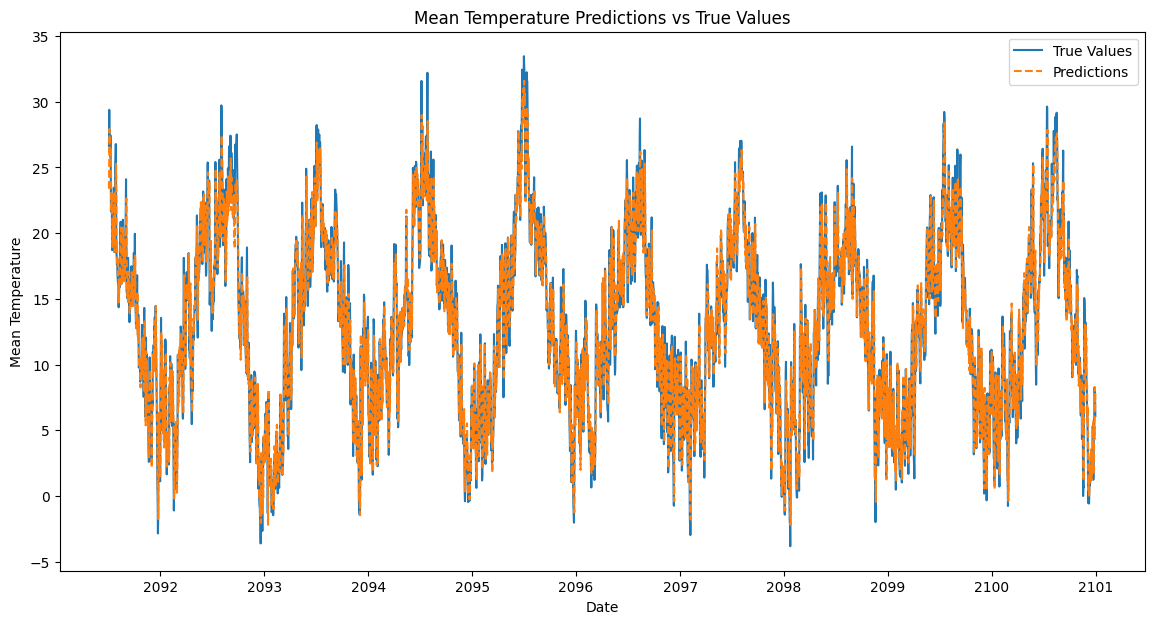

In [25]:
rmse = np.sqrt(mean_squared_error(y_test, bilstm_pred))
r2 = r2_score(y_test, bilstm_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_rcp_4_5.index[-len(y_test):], y_test, label='True Values')
plt.plot(data_rcp_4_5.index[-len(y_test):], bilstm_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

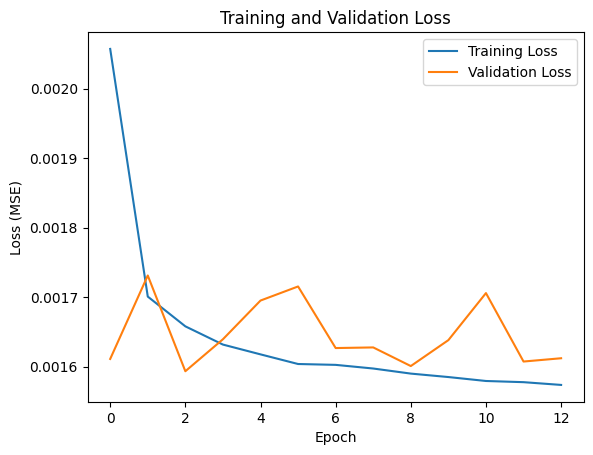

In [26]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
data_climate_reims_2009_2025.head()

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C_6H,TEMPERATURE_NOON_C_12H,TEMPERATURE_EVENING_C_18H,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,...,WEATHER_CODE_NIGHT_3H,TEMPERATURE_9H,WEATHER_CODE_9H,TEMPERATURE_15H,WEATHER_CODE_15H,TEMPERATURE_21H,WEATHER_CODE_21H,TEMPERATURE_MIDNIGHT_0H,WEATHER_CODE_MIDNIGHT_0H,MEAN_TEMPERATURE_C
DATE,,,,,,,,,,,,,,,,,,,,,
2009-01-01,3,-4,8,-3,3,-3,0.0,95,7.00,1029,...,143,-2,113,0,116,-4,113,-3,143,-1.875
2009-01-02,1,-5,15,-5,1,-2,0.0,88,10.00,1028,...,113,-4,113,0,113,-2,116,-5,113,-2.750
2009-01-03,1,-5,14,-4,1,-4,0.0,93,10.00,1028,...,116,-3,113,-1,113,-5,113,-3,116,-2.750
2009-01-04,-1,-6,8,-6,-1,-4,0.0,68,10.00,1026,...,116,-5,113,-3,119,-4,116,-6,113,-4.375
2009-01-05,-1,-4,10,-4,-1,-2,2.5,83,3.75,1021,...,338,-3,332,-1,338,-2,332,-4,119,-2.625


In [28]:
data_rcp_4_5.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2100-12-22', '2100-12-23', '2100-12-24', '2100-12-25',
               '2100-12-26', '2100-12-27', '2100-12-28', '2100-12-29',
               '2100-12-30', '2100-12-31'],
              dtype='datetime64[ns]', name='Date', length=34698, freq=None)

In [31]:
data_rcp_4_5_2009_2025.head()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
2009-01-01,49.2427,4.03882,0.24,7.58,3.68,0.00,0.0,4.064,55.525,281.157,2.79,0.097
2009-01-02,49.2427,4.03882,2.78,9.38,5.28,0.00,0.0,4.071,53.817,284.978,2.88,0.216
2009-01-03,49.2427,4.03882,1.96,8.07,5.52,0.00,0.0,3.969,53.894,298.094,1.62,0.112
2009-01-04,49.2427,4.03882,2.85,6.24,4.46,0.00,0.0,4.110,35.990,302.317,7.30,0.464
2009-01-05,49.2427,4.03882,0.94,2.90,2.13,0.07,0.0,3.738,23.631,302.138,3.97,0.286


In [ ]:
# Make predictions
bilstm_pred = model.predict(X_test)
bilstm_pred = target_transformer.inverse_transform(bilstm_pred)  # Inverse transform to original scale

array([[[0.64998021, 0.45369343, 0.42359963],
        [0.6800554 , 0.4472808 , 0.48539945],
        [0.757222  , 0.4232951 , 0.58347107]],

       [[0.6800554 , 0.4472808 , 0.48539945],
        [0.757222  , 0.4232951 , 0.58347107],
        [0.81499802, 0.43686028, 0.66795225]],

       [[0.757222  , 0.4232951 , 0.58347107],
        [0.81499802, 0.43686028, 0.66795225],
        [0.86960823, 0.41151807, 0.76574839]],

       ...,

       [[0.4024535 , 0.24694784, 0.02167126],
        [0.37831421, 0.24719448, 0.01836547],
        [0.45172141, 0.30533975, 0.03397612]],

       [[0.37831421, 0.24719448, 0.01836547],
        [0.45172141, 0.30533975, 0.03397612],
        [0.44796201, 0.26032803, 0.056382  ]],

       [[0.45172141, 0.30533975, 0.03397612],
        [0.44796201, 0.26032803, 0.056382  ],
        [0.43806886, 0.30373659, 0.07015611]]])

In [ ]:
data_climate_reims_2009_2025 = data_climate_reims_2009_2025[['MEAN_TEMPERATURE_C', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'hussAdjust', 'evspsblpotAdjust']]
data_rcp_4_5 = data_rcp_4_5[['tasAdjust', 'hussAdjust', 'evspsblpotAdjust']]
data_rcp_4_5.head()
data_climate_reims_2009_2025

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C_6H,TEMPERATURE_NOON_C_12H,TEMPERATURE_EVENING_C_18H,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,...,WEATHER_CODE_NIGHT_3H,TEMPERATURE_9H,WEATHER_CODE_9H,TEMPERATURE_15H,WEATHER_CODE_15H,TEMPERATURE_21H,WEATHER_CODE_21H,TEMPERATURE_MIDNIGHT_0H,WEATHER_CODE_MIDNIGHT_0H,MEAN_TEMPERATURE_C
DATE,,,,,,,,,,,,,,,,,,,,,
2009-01-01,3,-4,8,-3,3,-3,0.0,95,7.00,1029,...,143,-2,113,0,116,-4,113,-3,143,-1.875
2009-01-02,1,-5,15,-5,1,-2,0.0,88,10.00,1028,...,113,-4,113,0,113,-2,116,-5,113,-2.750
2009-01-03,1,-5,14,-4,1,-4,0.0,93,10.00,1028,...,116,-3,113,-1,113,-5,113,-3,116,-2.750
2009-01-04,-1,-6,8,-6,-1,-4,0.0,68,10.00,1026,...,116,-5,113,-3,119,-4,116,-6,113,-4.375
2009-01-05,-1,-4,10,-4,-1,-2,2.5,83,3.75,1021,...,338,-3,332,-1,338,-2,332,-4,119,-2.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-26,17,6,16,6,16,17,0.0,93,10.00,1021,...,113,11,113,17,122,13,116,8,116,11.875
2025-04-27,19,8,13,9,18,18,0.0,84,10.00,1025,...,116,14,116,19,119,14,116,11,116,14.250
2025-04-28,21,9,10,9,19,20,0.0,90,10.00,1026,...,113,15,113,21,116,12,113,11,116,14.500


In [35]:
data_climate_reims_2009_2025.columns

Index(['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C_6H', 'TEMPERATURE_NOON_C_12H',
       'TEMPERATURE_EVENING_C_18H', 'PRECIP_TOTAL_DAY_MM',
       'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM', 'PRESSURE_MAX_MB',
       'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C',
       'WINDTEMP_MAX_C', 'WEATHER_CODE_MORNING_6H', 'WEATHER_CODE_NOON_12H',
       'WEATHER_CODE_EVENING_18H', 'TOTAL_SNOW_MM', 'UV_INDEX', 'SUNHOUR',
       'OPINION', 'SUNSET', 'SUNRISE', 'TEMPERATURE_NIGHT_C_3H',
       'WEATHER_CODE_NIGHT_3H', 'TEMPERATURE_9H', 'WEATHER_CODE_9H',
       'TEMPERATURE_15H', 'WEATHER_CODE_15H', 'TEMPERATURE_21H',
       'WEATHER_CODE_21H', 'TEMPERATURE_MIDNIGHT_0H',
       'WEATHER_CODE_MIDNIGHT_0H', 'MEAN_TEMPERATURE_C'],
      dtype='object')

In [ ]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [96]:
a = np.array([ [22, 7], [17, 8], [15, 12], [7, 6], [13, 9], [14, 9], [10, 4], [3, 1], [0, 3] ])
b = np.array(a[:, 0])

In [97]:
a = pd.DataFrame(a, columns=["A", "B"])
a

,A,B
0,22,7
1,17,8
2,15,12
3,7,6
4,13,9
5,14,9
6,10,4
7,3,1
8,0,3


In [98]:
b = pd.DataFrame(b, columns=["A"])
b

,A
0,22
1,17
2,15
3,7
4,13
5,14
6,10
7,3
8,0


In [100]:
create_dataset(a, b, 3)

(array([[[22,  7],
         [17,  8],
         [15, 12]],
 
        [[17,  8],
         [15, 12],
         [ 7,  6]],
 
        [[15, 12],
         [ 7,  6],
         [13,  9]],
 
        [[ 7,  6],
         [13,  9],
         [14,  9]],
 
        [[13,  9],
         [14,  9],
         [10,  4]],
 
        [[14,  9],
         [10,  4],
         [ 3,  1]]]),
 array([[ 7],
        [13],
        [14],
        [10],
        [ 3],
        [ 0]]))

In [43]:
a = np.random.randn(10, 5).ravel()
a = pd.DataFrame(a, columns=["A"])
b, c, d = split_dataframe(a)

Train size : 35
Val size : 9
Test size : 6


In [44]:
c

,A
35,0.580969
36,1.856924
37,0.871386
38,-1.422149
39,1.655526
40,0.916884
41,-0.130959
42,-2.116208
43,0.199468


In [64]:
a.index[len(b)+len(c): -len(d)]
a

,A
0,0.524460
1,0.631009
2,0.836356
3,0.793134
4,1.342540
5,1.444228
6,0.067403
7,0.592664
8,0.889806
9,-0.893215


In [51]:
b

,A
0,0.524460
1,0.631009
2,0.836356
3,0.793134
4,1.342540
5,1.444228
6,0.067403
7,0.592664
8,0.889806
9,-0.893215


In [52]:
a

,A
0,0.524460
1,0.631009
2,0.836356
3,0.793134
4,1.342540
5,1.444228
6,0.067403
7,0.592664
8,0.889806
9,-0.893215
